In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.0.0+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
# print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Number of training nodes: {data.train_mask.sum()}')
# print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
# print(f'Has isolated nodes: {data.has_isolated_nodes()}')
# print(f'Has self-loops: {data.has_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556


In [ ]:
# a) From the Planetoid Cora dataset, extract the number of nodes that are in the training set, validation set, and test set. 

In [ ]:
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')

Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


In [ ]:
# Discuss briefly the implications for supervised versus semi-supervised learning.

In [ ]:
# b) Train both a standard dense network using supervised learning and network using the convolution from equation 1 using semi-supervised learning.

In [ ]:
# c) Use t-SNE to visualize the results.

In [ ]:
# Standard dense network
import torch
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import copy


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

mlp_model = MLP(hidden_channels=16)
print(mlp_model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [ ]:
mlp_model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

In [ ]:
def train():
      mlp_model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = mlp_model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(model):
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def validate(saved_models, accuracy):
    test_acc = test(mlp_model)
    accuracy = np.append(accuracy[1:], test_acc)
    model_copy = copy.deepcopy(mlp_model)
    saved_models = np.append(saved_models[1:], model_copy)
    return saved_models, accuracy

In [ ]:
# Since s_models is an array that will hold trained model objects, it doesn't make sense to initialize it with zeros or any other default value. 
# Instead, we want to initialize it to an "empty" state where we know that there are no actual models stored yet.

In [ ]:
early_stopping_threshold = 20
accuracies = np.zeros(early_stopping_threshold)
models = np.empty(early_stopping_threshold)
models[:] = np.NaN

for epoch in range(1, 201):
    loss = train()
    models, accuracies = validate(models, accuracies)
    # print(f'Saved Models: {models}')
    # print(f'Accuracies: {accuracies}')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if accuracies[0] == np.max(accuracies):
        best_mlp = models[0]
        break

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [ ]:
test_acc = test(best_mlp)
print(f'Test Accuracy (best MLP): {test_acc:.4f}')

Test Accuracy (best MLP): 0.5720


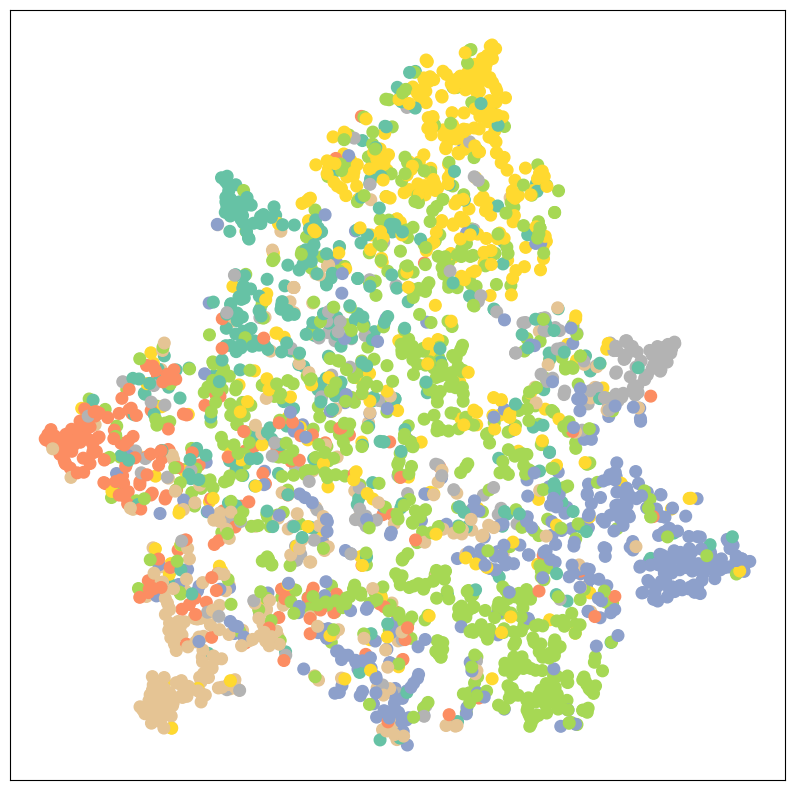

In [ ]:
best_mlp.eval()

out = best_mlp(data.x)
visualize(out, color=data.y)

In [ ]:
# Network using Graph Convolutions

In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

gcn_model = GCN(hidden_channels=16)
print(gcn_model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [ ]:
gcn_model = GCN(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

In [ ]:
def train():
      gcn_model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = gcn_model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(model):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def validate(saved_models, accuracy):
    test_acc = test(gcn_model)
    accuracy = np.append(accuracy[1:], test_acc)
    model_copy = copy.deepcopy(gcn_model)
    saved_models = np.append(saved_models[1:], model_copy)
    return saved_models, accuracy

In [ ]:
early_stopping_threshold = 20
accuracies = np.zeros(early_stopping_threshold)
models = np.empty(early_stopping_threshold)
models[:] = np.NaN

for epoch in range(1, 201):
    loss = train()
    models, accuracies = validate(models, accuracies)
    # print(f'Saved Models: {models}')
    # print(f'Accuracies: {accuracies}')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if accuracies[0] == np.max(accuracies):
        best_gcn = models[0]
        break

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9397
Epoch: 003, Loss: 1.9350
Epoch: 004, Loss: 1.9279
Epoch: 005, Loss: 1.9187
Epoch: 006, Loss: 1.9115
Epoch: 007, Loss: 1.9032
Epoch: 008, Loss: 1.8911
Epoch: 009, Loss: 1.8855
Epoch: 010, Loss: 1.8723
Epoch: 011, Loss: 1.8590
Epoch: 012, Loss: 1.8506
Epoch: 013, Loss: 1.8350
Epoch: 014, Loss: 1.8292
Epoch: 015, Loss: 1.8108
Epoch: 016, Loss: 1.8010
Epoch: 017, Loss: 1.7890
Epoch: 018, Loss: 1.7752
Epoch: 019, Loss: 1.7497
Epoch: 020, Loss: 1.7430
Epoch: 021, Loss: 1.7419
Epoch: 022, Loss: 1.7190
Epoch: 023, Loss: 1.6953
Epoch: 024, Loss: 1.6846
Epoch: 025, Loss: 1.6622
Epoch: 026, Loss: 1.6432
Epoch: 027, Loss: 1.6315
Epoch: 028, Loss: 1.5924
Epoch: 029, Loss: 1.5925
Epoch: 030, Loss: 1.5740
Epoch: 031, Loss: 1.5494
Epoch: 032, Loss: 1.5583
Epoch: 033, Loss: 1.5199
Epoch: 034, Loss: 1.5044
Epoch: 035, Loss: 1.4792
Epoch: 036, Loss: 1.4697
Epoch: 037, Loss: 1.4162
Epoch: 038, Loss: 1.4125
Epoch: 039, Loss: 1.3977
Epoch: 040, Loss: 1.3814


In [ ]:
test_acc = test(best_gcn)
print(f'Test Accuracy (best GCN): {test_acc:.4f}')

Test Accuracy (best GCN): 0.8130


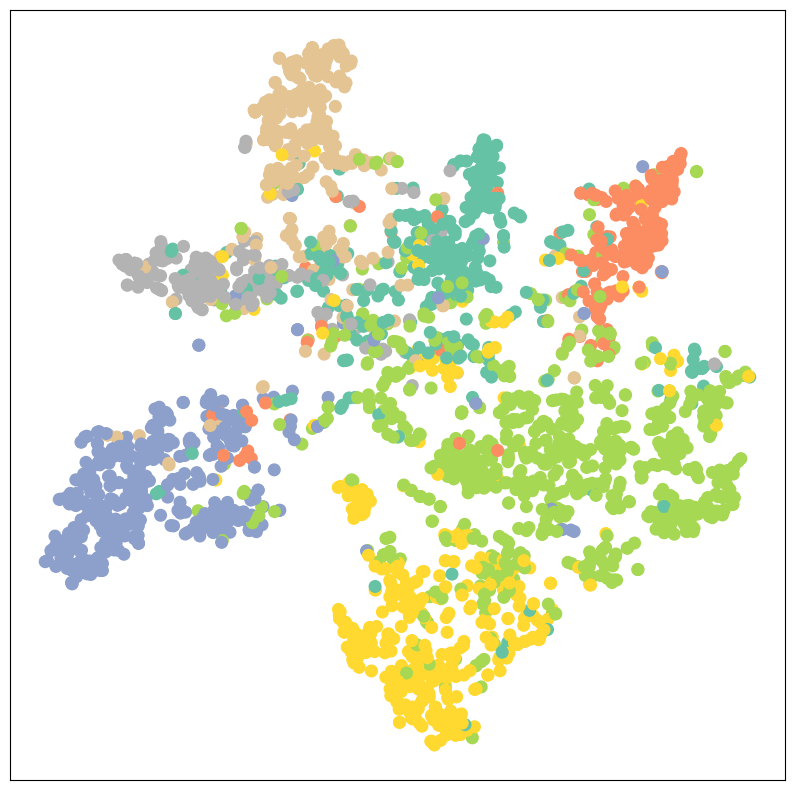

In [ ]:
best_gcn.eval()

out = best_gcn(data.x, data.edge_index)
visualize(out, color=data.y)